In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the data

In [75]:
# loading data
df = pd.read_csv('/content/British_reviews_skytrax.csv')
print(f"Dataset shape: {df.shape}")
print(df.info())
print(df.head())

Dataset shape: (3400, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3400 non-null   int64 
 1   reviews     3400 non-null   object
dtypes: int64(1), object(1)
memory usage: 53.3+ KB
None
   Unnamed: 0                                            reviews
0           0  ✅ Trip Verified |  I was flying to Warsaw for ...
1           1  ✅ Trip Verified |  Booked a BA holiday to Marr...
2           2  ✅ Trip Verified | Extremely sub-par service. H...
3           3  ✅ Trip Verified |  I virtually gave up on Brit...
4           4  ✅ Trip Verified |  I was pleasantly surprised ...


In [76]:
df.columns = ['reviewid', 'reviews']

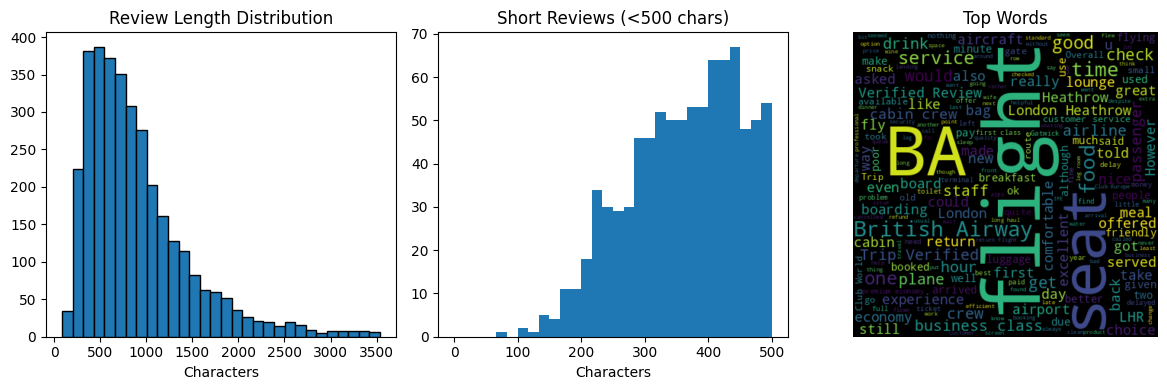

Average length: 896 chars
Null reviews: 0


In [69]:
# reviewing length distribution
df['review_length'] = df['reviews'].str.len()
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title('Review Length Distribution')
plt.xlabel('Characters')

plt.subplot(1, 3, 2)
plt.hist(df['review_length'], bins=30, range=(0, 500))
plt.title('Short Reviews (<500 chars)')
plt.xlabel('Characters')

# Word cloud
plt.subplot(1, 3, 3)
stop_words = set(stopwords.words('english'))
text = ' '.join(df['reviews'].astype(str))
wordcloud = WordCloud(width=400, height=400,
                     stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words')

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average length: {df['review_length'].mean():.0f} chars")
print(f"Null reviews: {df['reviews'].isna().sum()}")

# Data Preprocessing

In [70]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # lowercase & remove URLs, special chars
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # tokenize & lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# applying preprocessing
print("Preprocessing...")
df['clean_text'] = df['reviews'].apply(preprocess_text)
print(f"Sample: {df['clean_text'].iloc[0][:100]}...")
print(f"Empty texts: { (df['clean_text'].str.len() == 0).sum() }")

Preprocessing...
Sample: trip verified flying warsaw one day meeting would flying back miami next day initially flight delaye...
Empty texts: 0


In [71]:
import re
from collections import Counter

def enhanced_sentiment(text):
    text = text.lower()


    neg_words = {
        'service': ['terrible', 'awful', 'worst', 'disappointed', 'horrible',
                   'rude', 'unhelpful', 'poor', 'bad', 'uncomfortable'],
        'flight': ['delay', 'cancel', 'late', 'missed', 'turbulence'],
        'crew': ['unfriendly', 'ignorant', 'slow'],
        'food': ['inedible', 'disgusting', 'cold']
    }

    pos_words = {
        'service': ['excellent', 'amazing', 'fantastic', 'perfect', 'great',
                   'wonderful', 'friendly', 'helpful', 'efficient'],
        'flight': ['smooth', 'on-time', 'punctual'],
        'crew': ['courteous', 'attentive', 'professional'],
        'food': ['delicious', 'tasty', 'fresh']
    }

    neg_patterns = ['not good', 'not happy', 'would not recommend', 'never again']
    pos_patterns = ['highly recommend', 'will fly again', 'best ever']

    # calculating score of positive and negative words
    neg_score, pos_score = 0, 0

    # word scores (weighted by category)
    for category, words in neg_words.items():
        neg_score += sum(1 if word in text else 0 for word in words)
    for category, words in pos_words.items():
        pos_score += sum(1 if word in text else 0 for word in words)

    # pattern scores (x2 weight)
    neg_score += 2 * sum(1 if pattern in text else 0 for pattern in neg_patterns)
    pos_score += 2 * sum(1 if pattern in text else 0 for pattern in pos_patterns)

    # negation handling
    if any(neg in text for neg in ['not', 'no', 'never', 'worst']):
        neg_score *= 1.5  # boosting negatives with negation

    # threshold decision
    diff = pos_score - neg_score

    if diff >= 2: return 'positive'
    elif diff <= -2: return 'negative'
    else: return 'neutral'

# REPLACE Step 3.2
df['sentiment'] = df['clean_text'].apply(enhanced_sentiment)
print("ENHANCED LABELS:")
print(df['sentiment'].value_counts())

ENHANCED LABELS:
sentiment
neutral     1946
negative     991
positive     463
Name: count, dtype: int64


In [72]:
# removing empty texts
df_clean = df[df['clean_text'].str.len() > 0].copy()
print(f"Final dataset: {df_clean.shape}")
df_clean[['reviewid', 'clean_text', 'sentiment']].to_csv('processed_data.csv', index=False)

Final dataset: (3400, 5)


# Model Training

In [73]:
X = df_clean['clean_text']
y = df_clean['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (2720,), Test: (680,)


In [78]:
# Logistic Regression
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
print("LOGISTIC REGRESSION F1: {:.3f}".format(f1_score(y_test, y_pred_lr, average='weighted')))

# Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(random_state=42, n_estimators=100))
])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
print("RANDOM FOREST F1: {:.3f}".format(f1_score(y_test, y_pred_rf, average='weighted')))

# Gradient Boosting
pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42, n_estimators=100))
])
pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)
print("GRADIENT BOOSTING F1: {:.3f}".format(f1_score(y_test, y_pred_gb, average='weighted')))

LOGISTIC REGRESSION F1: 0.683
RANDOM FOREST F1: 0.703
GRADIENT BOOSTING F1: 0.812
